In [103]:
import pandas as pd
import glob
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load basket data
basket_df = pd.read_csv("data/company_basket.csv", sep=";")

# Load all Sweden stock data files
stock_files = glob.glob("data/Sweden_*.txt")
stock_data = pd.concat([pd.read_csv(f, sep=";") for f in stock_files])

# Ensure all companies have an industry and sector
stock_data["industry_name"] = stock_data["industry_name"].fillna("Unknown")
stock_data["economic_sector_name"] = stock_data["economic_sector_name"].fillna("Unknown")

# One-hot encode industry_name and economic_sector_name
industry_encoded = pd.get_dummies(stock_data[['company_name', 'industry_name']], columns=['industry_name'])
sector_encoded = pd.get_dummies(stock_data[['company_name', 'economic_sector_name']], columns=['economic_sector_name'])

# Merge one-hot encoded data to create stock_features
stock_features = pd.concat([industry_encoded, sector_encoded.drop("company_name", axis=1)], axis=1)
# Group by company_name to consolidate multiple entries per company
stock_features = stock_features.groupby("company_name").max().astype(int).reset_index()

In [104]:
stock_features.head()

,company_name,industry_name_Advanced Medical Equipment & Technology,industry_name_Advertising & Marketing,industry_name_Aerospace & Defense,industry_name_Agricultural Chemicals,industry_name_Airlines,industry_name_Aluminum,industry_name_Apparel & Accessories,industry_name_Apparel & Accessories Retailers,"industry_name_Appliances, Tools & Housewares",...,economic_sector_name_Basic Materials,economic_sector_name_Consumer Cyclicals,economic_sector_name_Consumer Non-Cyclicals,economic_sector_name_Energy,economic_sector_name_Financials,economic_sector_name_Healthcare,economic_sector_name_Industrials,economic_sector_name_Real Estate,economic_sector_name_Technology,economic_sector_name_Utilities
0,24SevenOffice Scandinavia AB,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2cureX AB,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,4C Group AB,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,AAC Clyde Space AB,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,AAK AB (publ),0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [105]:
def create_basket_features(basket_df, stock_features):
    # Convert shares to decimals
    basket_df['company_share'] = basket_df['company_share'] / 100.0
    
    # Get feature columns
    feature_cols = stock_features.columns.drop('company_name')
    
    # Merge and calculate weighted features
    merged = pd.merge(basket_df, stock_features, on='company_name')
    for col in feature_cols:
        merged[col] = merged[col] * merged['company_share']
    
    # Sum features for each basket
    basket_features = merged.groupby('basket_name')[feature_cols].sum()
    
    return basket_features.reset_index()

# Create basket features
basket_features = create_basket_features(basket_df, stock_features)

In [106]:
basket_features.head()

,basket_name,industry_name_Advanced Medical Equipment & Technology,industry_name_Advertising & Marketing,industry_name_Aerospace & Defense,industry_name_Agricultural Chemicals,industry_name_Airlines,industry_name_Aluminum,industry_name_Apparel & Accessories,industry_name_Apparel & Accessories Retailers,"industry_name_Appliances, Tools & Housewares",...,economic_sector_name_Basic Materials,economic_sector_name_Consumer Cyclicals,economic_sector_name_Consumer Non-Cyclicals,economic_sector_name_Energy,economic_sector_name_Financials,economic_sector_name_Healthcare,economic_sector_name_Industrials,economic_sector_name_Real Estate,economic_sector_name_Technology,economic_sector_name_Utilities
0,Aluminium,0.0,0.0,0.000000,0.0,0.0,0.066667,0.0,0.0,0.0,...,0.066667,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,BIG INDEX Global,0.0,0.0,0.004657,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000995,0.004657,0.0,0.0,0.0
2,Biotech EBITDA>0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.005405,0.000000,0.0,0.0,0.0
3,Biotech MCAP >30 m and < 80 m,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.020588,0.000000,0.0,0.0,0.0
4,Broadcasting companiess,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.033333,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [102]:
# Compute cosine similarity matrix (n_basket, n_basket)
similarity_matrix = cosine_similarity(basket_features.iloc[:, 1:].values)

# Get the basket index mapping from unique baskets
basket_to_idx = {name: idx for idx, name in enumerate(basket_features['basket_name'])}

# Function to get similar baskets
def get_similar_baskets(basket_name, similarity_matrix, n=10): 
    if basket_name not in basket_features['basket_name'].values:
        print("\nAvailable baskets:")
        print(sorted(basket_features['basket_name'].unique()))
        raise ValueError(f"\nBasket '{basket_name}' not found in the data")

    # Get index for the target basket
    target_idx = basket_to_idx[basket_name]
    
    similarity_scores = list(enumerate(similarity_matrix[target_idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:n+1]

    # Get basket names corresponding to top similar indices
    similar_baskets = [list(basket_idx.keys())[i[0]] for i in similarity_scores]

    return similar_baskets

try:
    # Try with a basket name that exists in the data
    similar = get_similar_baskets("BIG INDEX Global", similarity_matrix, n=10)
    print("\nSimilar baskets to 'BIG INDEX Global':")
    print(similar)
except ValueError as e:
    print(e)


Similar baskets to 'BIG INDEX Global':
['Consumer loans', 'china big', 'balt business', 'Blockchain and crypto', 'Consumers in Europe', 'Design and Furnishing', 'Food world 7', 'Food world 6', 'German companies', 'biotech Sweden']


In [79]:
stock_features.iloc[0].value_counts()

0
0                               120
1                                 2
24SevenOffice Scandinavia AB      1
Name: count, dtype: int64

In [80]:
sector_encoded.iloc[0].value_counts()

0
False                    10
Concordia Maritime AB     1
True                      1
Name: count, dtype: int64

In [81]:
industry_encoded.iloc[0].value_counts()

0
False                    110
Concordia Maritime AB      1
True                       1
Name: count, dtype: int64

In [83]:
merged = pd.merge(basket_df, stock_features, on='company_name')
merged
wtf_rows = merged[merged['basket_name'] == "WTF II"]
print("Found rows:", len(wtf_rows))

Found rows: 0


Number of unique baskets: 197
Number of baskets in features: 85
Number of baskets in mapping: 85
Missing companies:
                         basket_name          company_name  company_share
0     a123456789b123456789c123456789     Gaming Realms PLC      22.474253
1     a123456789b123456789c123456789   Intercede Group PLC      15.830177
2     a123456789b123456789c123456789            Jujubee SA       0.612906
4     a123456789b123456789c123456789            Osmozis SA      16.675088
5     a123456789b123456789c123456789        Vigo System SA      11.200388
...                              ...                   ...            ...
3278                          WTF II            Capitea SA       1.243451
3279                          WTF II   Dolphin Drilling AS      55.178652
3280                          WTF II  Energy Solar Tech SA       4.256468
3281                          WTF II       Kibo Energy PLC       0.709684
3282                          WTF II  Live Motion Games SA       0.247

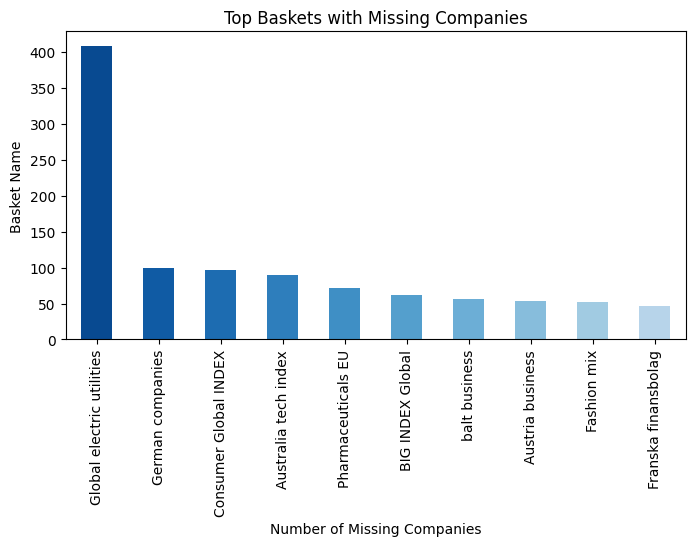

In [97]:
# Debug information
num_baskets = basket_df['basket_name'].nunique()
print(f"Number of unique baskets: {num_baskets}")
print("Number of baskets in features:", len(basket_features))
print("Number of baskets in mapping:", len(basket_to_idx))

# Check companies in basket_df that aren't in stock_features
missing_companies = basket_df[~basket_df['company_name'].isin(stock_features['company_name'])]
print("Missing companies:")
print(missing_companies)

# Check how many companies are lost per basket
lost_companies = missing_companies.groupby('basket_name')['company_name'].count()
lost_companies = lost_companies.sort_values(ascending=False)
n_lost_companies = 10
plt.figure(figsize=(8, 4))
colors = plt.cm.Blues(np.linspace(0.9, 0.3, n_lost_companies))
lost_companies.head(n_lost_companies).plot(kind='bar', color=colors)
plt.title('Top Baskets with Missing Companies')
plt.xlabel('Number of Missing Companies')
plt.ylabel('Basket Name')
print("\nNumber of lost companies per basket:")
print(lost_companies)